In [1]:
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.models import load_model

Using TensorFlow backend.


In [2]:
# training path
train_path = 'dataset/train'
test_path = 'dataset/test'

train_img_list = os.listdir(train_path)
test_img_list = os.listdir(test_path)

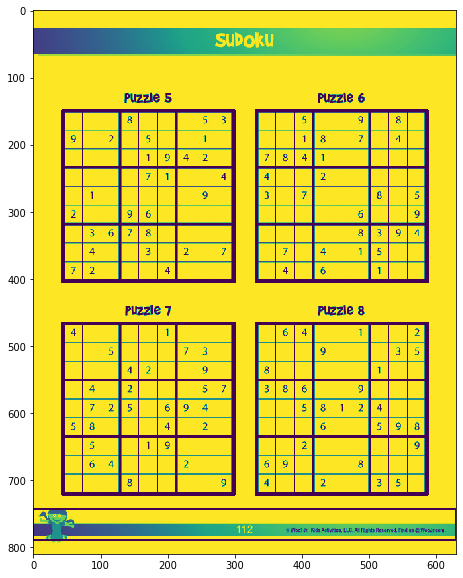

In [3]:
# read image in grayscale mode
#img = cv2.imread(os.path.join(train_path, train_img_list[0]), cv2.IMREAD_GRAYSCALE)
img = cv2.imread('dataset/image00.jpg', cv2.IMREAD_GRAYSCALE)

# Convert Images to Grayscale
gray = img.copy()

# Do Gaussian Blur in order to remove noise
#gray = cv2.GaussianBlur(gray, (9, 9), 0)

# do adaptive thresholding and convert images to binary
gray = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
             cv2.THRESH_BINARY,11,2)

# convert to black on white 
gray = cv2.bitwise_not(gray, gray)

# dilate the gridlines
#kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]],np.uint8)
#gray = cv2.dilate(gray, kernel)

# find contours (Sudoku Grid)
contours,hierarchy = cv2.findContours(gray, 1, 2)
contours = sorted(contours, key=cv2.contourArea, reverse=True) # sort contours by area
polygon_arr = contours[0:5]  # extract up to 5 sudoku grid at once

cropped_arr = []
cropped_arr_orig = []
bbox_arr = []
orig_gray = gray.copy()
orig = img.copy()
# enumerate to draw rectangle and crop
for polygon in polygon_arr:
    x,y,w,h = cv2.boundingRect(polygon)
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
    bbox_arr.append((x,y,w,h))
    cropped_arr.append(orig_gray[y:y+h, x:x+w])
    cropped_arr_orig.append(orig[y:y+h, x:x+w])
    
plt.figure(figsize=(10,10))
plt.imshow(img)

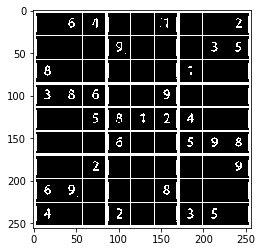

In [4]:
plt.imshow(cropped_arr[0], 'gray')

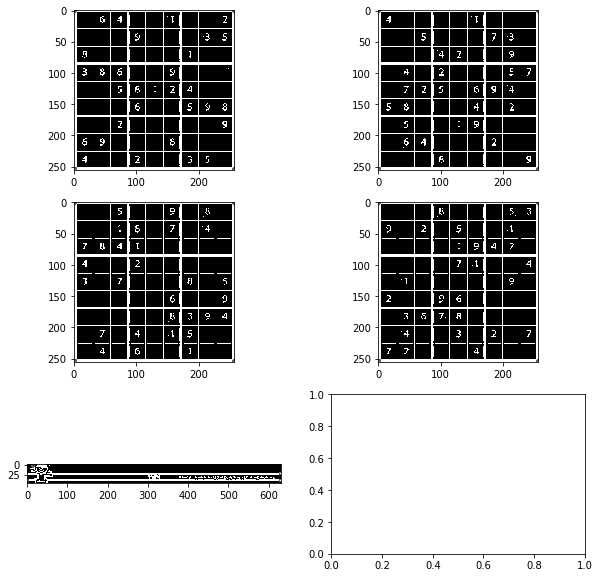

In [5]:
fig,ax = plt.subplots(3,2, figsize=(10,10))
ax = ax.ravel()
all_edges = []

for i in range(5):
    # detect edges
    img1 = cropped_arr[i].copy()

    # find contours (Sudoku Grid)
    contours,hierarchy = cv2.findContours(img1, 1, 2)
    contours = sorted(contours, key=cv2.contourArea, reverse=True) # sort contours by area
    polygon = np.array(contours[0]).reshape(-1,2) #take the largest contour region

    sums = [elem[0] + elem[1] for elem in polygon] # X + Y
    diff1 = [elem[0] - elem[1] for elem in polygon] # X - Y

    top_left = np.argmin(sums) # smallest X + Y values
    bottom_right = np.argmax(sums) # largest X + Y values
    bottom_left = np.argmin(diff1) # smallest X - Y values
    top_right = np.argmax(diff1) # largest X - Y values

    # convert to tuple
    edges = [tuple(polygon[top_left]), tuple(polygon[top_right]), 
             tuple(polygon[bottom_right]), tuple(polygon[bottom_left])]
    all_edges.append(edges)

    # draw edges with gray circle
    for elem_edge in edges:
        cv2.circle(img1, elem_edge, 3, (100,100,255), 2)

    ax[i].imshow(img1, 'gray')

In [6]:
# filter only valid images
valid_sudoku_images = list(range(5))
to_remove = []

# check if edges are within 50 pixels in the corner.
for elem in valid_sudoku_images:
    if all_edges[elem][0][0] > 50 or all_edges[elem][0][1] > 50: # top left of image not very close to edge
        to_remove.append(elem)

valid_sudoku_images = [x for x in valid_sudoku_images if x not in to_remove]  # remove invalid

img_size_area = [elem.shape[0] * elem.shape[1] for elem in cropped_arr] # find area
max_area = np.max(img_size_area) # get maximum area
for elem in valid_sudoku_images:
    if img_size_area[elem] / max_area < 0.5: # less than 50% of max area
        to_remove.append(elem)

valid_sudoku_images = [x for x in valid_sudoku_images if x not in to_remove] # remove invalid

In [7]:
print('valid sudoku images: ', valid_sudoku_images)
cropped_arr = [x for idx, x in enumerate(cropped_arr) if idx in valid_sudoku_images]
print('len cropped arr', len(cropped_arr))

valid sudoku images:  [0, 1, 2, 3]
len cropped arr 4


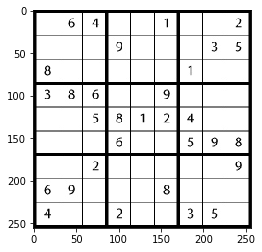

In [8]:
plt.imshow(cropped_arr_orig[0], 'gray')

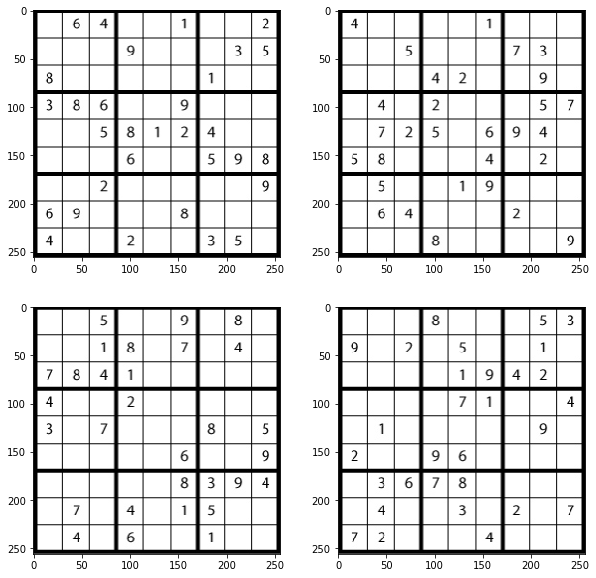

In [9]:
def distance_between(p1, p2):
    """Returns the euclidean distance between two points"""
    a = p2[0] - p1[0]
    b = p2[1] - p1[1]
    return np.sqrt((a ** 2) + (b ** 2))

all_M = []
fig,ax = plt.subplots(2,2, figsize=(10,10))
ax = ax.ravel()
final_proc = []

if len(valid_sudoku_images) == 0:
    valid_sudoku_images.append(0)
    all_edges = []
    h,w = cropped_arr_orig[0].shape
    all_edges = [[(0,0), (h,0), (h,w), (0,w)],]

for idx, elem in enumerate(valid_sudoku_images): 
    # extract edges
    top_left, top_right, bottom_right, bottom_left = all_edges[elem][0], all_edges[elem][1], all_edges[elem][2], all_edges[elem][3]
    
    # get longest edge of rectangle to warp
    side = max([distance_between(top_left, top_right), 
                 distance_between(top_right, bottom_right),
                 distance_between(bottom_right, bottom_left),
                 distance_between(bottom_left, top_left),
                ])
    
    # Describe a square with side of the calculated length, this is the new perspective we want to warp to
    pts2 = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')
    
    # transforms image from tilted to straight
    pts1 = np.float32(all_edges[elem])
#     pts2 = np.float32([[0,0],[225,0],[0,225],[225,225]])  # destination output

    # M is matrix for transformation
    M = cv2.getPerspectiveTransform(pts1,pts2)
    all_M.append(M)

    # output
    dst = cv2.warpPerspective(cropped_arr_orig[idx],M,(int(side),int(side)))
    final_proc.append(dst)
    ax[idx].imshow(dst, 'gray')

In [10]:
final_proc_final = []
# preproces finalboard
for elem in final_proc:
    # gaussian blur
    #proc = cv2.GaussianBlur(elem.copy(), (9, 9), 0)

    # Adaptive threshold using 11 nearest neighbour pixels
    proc = elem.copy()
    proc = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    # Invert colours, so gridlines have non-zero pixel values.
    # Necessary to dilate the image, otherwise will look like erosion instead.
    proc = cv2.bitwise_not(proc, proc)
    #kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]],np.uint8)
    #proc = cv2.dilate(proc, kernel)
    
    final_proc_final.append(proc)

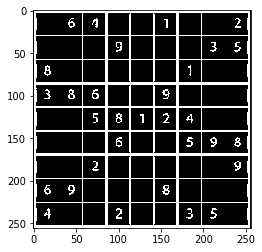

In [11]:
plt.imshow(final_proc_final[0], 'gray')

In [12]:
def find_bounding_box(inp_img, scan_top_left, scan_bot_right):
    img = inp_img.copy()
    h, w = img.shape

    max_area = 0
    seed_point = (None, None)

    # Loop through the image
    for x in range(scan_top_left[0], scan_bot_right[0]):
        for y in range(scan_top_left[1], scan_bot_right[1]):
            # if current square is white, fill it with grey
            # flood fill converts neighboring pixels with similar color to white
            if img.item(y, x) == 255 and x < w and y < h:  # Note that .item() appears to take input as y, x
                area = cv2.floodFill(img, None, (x, y), 64)
                if area[0] > max_area:  # Gets the maximum bound area which should be the grid, and set start pt
                    max_area = area[0]
                    seed_point = (x, y)

    # Colour everything grey (compensates for features outside of our middle scanning range)
    for x in range(w):
        for y in range(h):
            if img.item(y, x) == 255 and x < w and y < h:
                cv2.floodFill(img, None, (x, y), 64)

    mask = np.zeros((h + 2, w + 2), np.uint8)  # Mask that is 2 pixels bigger than the image (from documentation)

    # Highlight the main feature, fill it with white
    if all([p is not None for p in seed_point]):
        cv2.floodFill(img, mask, seed_point, 255)

    top, bottom, left, right = h, 0, w, 0
    
    # fill those that are grey with black to hide anything that is not the main feature
    for x in range(w):
        for y in range(h):
            if img.item(y, x) == 64:  # Hide anything that isn't the main feature
                cv2.floodFill(img, mask, (x, y), 0)
            
            # Find the bounding parameters (find the last contiguous x and y)
            if img.item(y, x) == 255:
                top = y if y < top else top
                bottom = y if y > bottom else bottom
                left = x if x < left else left
                right = x if x > right else right

    # returns the bounding box of the characters
    return left, top, right, bottom

In [13]:
def center_pad_images(img, orig_size):
    h,w = img.shape
    
    top_pad = int((orig_size - h) / 2)
    left_pad = int((orig_size - w) / 2)
    
    final =  cv2.copyMakeBorder(img.copy(), top_pad, top_pad, left_pad, left_pad, cv2.BORDER_CONSTANT, None, 0)
    return cv2.resize(final, (28, 28))

In [14]:
def scale_and_centre(img, size, margin=0, background=0):
	"""Scales and centres an image onto a new background square."""
	h, w = img.shape[:2]

	def centre_pad(length):
		"""Handles centering for a given length that may be odd or even."""
		if length % 2 == 0:
			side1 = int((size - length) / 2)
			side2 = side1
		else:
			side1 = int((size - length) / 2)
			side2 = side1 + 1
		return side1, side2

	def scale(r, x):
		return int(r * x)

	if h > w:
		t_pad = int(margin / 2)
		b_pad = t_pad
		ratio = (size - margin) / h
		w, h = scale(ratio, w), scale(ratio, h)
		l_pad, r_pad = centre_pad(w)
	else:
		l_pad = int(margin / 2)
		r_pad = l_pad
		ratio = (size - margin) / w
		w, h = scale(ratio, w), scale(ratio, h)
		t_pad, b_pad = centre_pad(h)

	img = cv2.resize(img, (w, h))
	img = cv2.copyMakeBorder(img, t_pad, b_pad, l_pad, r_pad, cv2.BORDER_CONSTANT, None, background)
	return cv2.resize(img, (size, size))

In [15]:
# split into 9x9 grids
board_arr = []
for board in final_proc_final:
    one_side_length = board.shape[0] / 9
    temp = []
    for i in range(9):
        lc = int(i * one_side_length)
        for j in range(9):
            rc = int(j * one_side_length)
            # currbox raw just take the raw pixels
            currbox = board[lc:int(lc+one_side_length), rc:int(rc+one_side_length)]
            margin = int(currbox.shape[0] / 2.5)    
            # get bounding box, input the scanning region
            left, top, right, bottom = find_bounding_box(currbox, [margin, margin], 
                                                         [currbox.shape[0] - margin, currbox.shape[1] - margin]) 
            # there is no object in the current box (set everything to black)
            if left == top and right == bottom:
                currbox = np.zeros((28,28))
            # crop the digits in the image
            else:
                currbox = currbox[top:bottom + 2, left:right + 2]
                # center and pad the images
                #currbox = center_pad_images(currbox, int(one_side_length))     
                currbox = scale_and_centre(currbox, 28,4)
                # binary tresholding
                currbox = cv2.threshold(currbox,80, 255, cv2.THRESH_BINARY)[1]
                
            # add them to the array row wise
            temp.append(currbox)            
    board_arr.append(temp)
    
board_arr = np.array(board_arr)

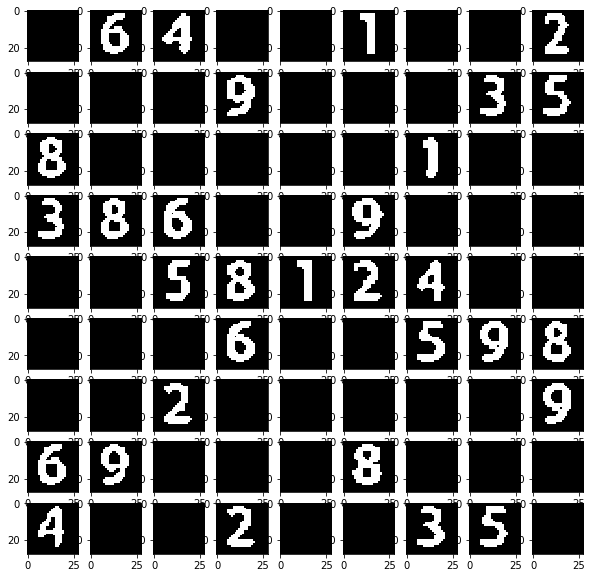

In [16]:
fig, ax =  plt.subplots(9,9, figsize=(10,10))
ax = ax.ravel()

for idx in range(81):    
    ax[idx].imshow(board_arr[0][idx], 'gray')

In [17]:
# load from saved pre-trained model (LeNet-5 Architecture)
model = tf.keras.models.load_model('digit_recognizer_best.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1600)              6

In [29]:
sudoku_board = []

for i in range(board_arr.shape[0]):
    temp = []
    for j in range(board_arr.shape[1]):
        if len(np.where(board_arr[i][j][7:17, 7:17].ravel() == 0)[0])/100 > 0.9:  # percentage of 0 which is black
            temp.append('0')
        else:
            curr_box = board_arr[i][j].reshape(1,28,28,1) / 255
            y_pred = np.argmax(model.predict(curr_box), axis=-1)[0]
            if y_pred == 0:
                curr_pred = model.predict(curr_box).ravel()
                maxs_idx = curr_pred.argsort()[-2:]
                y_pred = maxs_idx[0]
            temp.append(y_pred)
            
    sudoku_board.append(temp)

In [30]:
np.array(sudoku_board[0]).reshape(9,9)

array([['0', '6', '4', '0', '0', '1', '0', '0', '2'],
       ['0', '0', '0', '9', '0', '0', '0', '3', '5'],
       ['8', '0', '0', '0', '0', '0', '1', '0', '0'],
       ['3', '8', '6', '0', '0', '9', '0', '0', '0'],
       ['0', '0', '5', '8', '1', '2', '4', '0', '0'],
       ['0', '0', '0', '6', '0', '0', '5', '9', '8'],
       ['0', '0', '2', '0', '0', '0', '0', '0', '9'],
       ['6', '9', '0', '0', '0', '8', '0', '0', '0'],
       ['4', '0', '0', '2', '0', '0', '3', '5', '0']], dtype='<U1')

In [31]:
def cross(A, B):
    "Cross product of elements in A and elements in B."
    return [a+b for a in A for b in B]

digits   = '123456789'
rows     = 'ABCDEFGHI'
cols     = digits
squares  = cross(rows, cols)
unitlist = ([cross(rows, c) for c in cols] +
            [cross(r, cols) for r in rows] +
            [cross(rs, cs) for rs in ('ABC','DEF','GHI') for cs in ('123','456','789')])
units = dict((s, [u for u in unitlist if s in u]) 
             for s in squares)
peers = dict((s, set(sum(units[s],[]))-set([s]))
             for s in squares)

In [32]:
def parse_grid(grid):
    """Convert grid to a dict of possible values, {square: digits}, or
    return False if a contradiction is detected."""
    ## To start, every square can be any digit; then assign values from the grid.
    values = dict((s, digits) for s in squares)
    for s,d in grid_values(grid).items():
        if d in digits and not assign(values, s, d):
            return False ## (Fail if we can't assign d to square s.)
    return values

def grid_values(grid):
    "Convert grid into a dict of {square: char} with '0' or '.' for empties."
    chars = [c for c in grid if c in digits or c in '0.']
    assert len(chars) == 81
    return dict(zip(squares, chars))

In [33]:
def assign(values, s, d):
    """Eliminate all the other values (except d) from values[s] and propagate.
    Return values, except return False if a contradiction is detected."""
    other_values = values[s].replace(d, '')
    if all(eliminate(values, s, d2) for d2 in other_values):
        return values
    else:
        return False

def eliminate(values, s, d):
    """Eliminate d from values[s]; propagate when values or places <= 2.
    Return values, except return False if a contradiction is detected."""
    if d not in values[s]:
        return values ## Already eliminated
    values[s] = values[s].replace(d,'')
    ## (1) If a square s is reduced to one value d2, then eliminate d2 from the peers.
    if len(values[s]) == 0:
        return False ## Contradiction: removed last value
    elif len(values[s]) == 1:
        d2 = values[s]
        if not all(eliminate(values, s2, d2) for s2 in peers[s]):
            return False
    ## (2) If a unit u is reduced to only one place for a value d, then put it there.
    for u in units[s]:
        dplaces = [s for s in u if d in values[s]]
    if len(dplaces) == 0:
        return False ## Contradiction: no place for this value
    elif len(dplaces) == 1:
        # d can only be in one place in unit; assign it there
        if not assign(values, dplaces[0], d):
            return False
    return values

In [34]:
def display(values):
    "Display these values as a 2-D grid."
    width = 1+max(len(values[s]) for s in squares)
    line = '+'.join(['-'*(width*3)]*3)
    for r in rows:
        print (''.join(values[r+c].center(width)+('|' if c in '36' else '')
                      for c in cols))
        if r in 'CF': print (line)
    print()

In [56]:
a_str = ''.join(str(x) for x in sudoku_board[0])
display(parse_grid(a_str))

  5    6    4  |  37  378   1  |  9    78   2  
  1    2    7  |  9   468   46 |  68   3    5  
  8    3    9  | 457   2   4567|  1    47  467 
---------------+---------------+---------------
  3    8    6  | 457  457   9  |  27  127   17 
  9    7    5  |  8    1    2  |  4    6    3  
  2    4    1  |  6    37   37 |  5    9    8  
---------------+---------------+---------------
  7    5    2  | 134  346  346 |  68  148   9  
  6    9    3  | 1457 457   8  |  27  1247 147 
  4    1    8  |  2    9    67 |  3    5    67 



In [57]:
# https://norvig.com/sudoku.html
def solve(grid): return search(parse_grid(grid))

def search(values):
    "Using depth-first search and propagation, try all possible values."
    if values is False:
        return False ## Failed earlier
    if all(len(values[s]) == 1 for s in squares): 
        return values ## Solved!
    ## Chose the unfilled square s with the fewest possibilities
    n,s = min((len(values[s]), s) for s in squares if len(values[s]) > 1)
    return some(search(assign(values.copy(), s, d)) for d in values[s])

def some(seq):
    "Return some element of seq that is true."
    for e in seq:
        if e: return e
    return False

In [58]:
display(solve(a_str))

5 6 4 |3 8 1 |9 7 2 
1 2 7 |9 6 4 |8 3 5 
8 3 9 |7 2 5 |1 4 6 
------+------+------
3 8 6 |4 5 9 |7 2 1 
9 7 5 |8 1 2 |4 6 3 
2 4 1 |6 3 7 |5 9 8 
------+------+------
7 5 2 |1 4 3 |6 8 9 
6 9 3 |5 7 8 |2 1 4 
4 1 8 |2 9 6 |3 5 7 

